All of these I changed ANNEAL_LR to False

In [1]:
!hostname
!pwd

freeman-titanxp-5.csail.mit.edu
/data/vision/phillipi/akumar01/synthetic-mdps/src/ablations


# ORIGINAL PUREJAXRL

2023-11-21 04:10:22.098042: W external/xla/xla/service/gpu/nvptx_compiler.cc:673] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


{'discount': (32, 976, 128, 4), 'returned_episode': (32, 976, 128, 4), 'returned_episode_lengths': (32, 976, 128, 4), 'returned_episode_returns': (32, 976, 128, 4), 'timestep': (32, 976, 128, 4)}


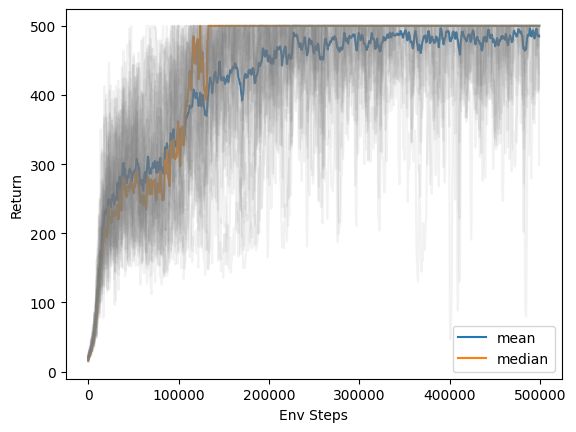

In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import gymnax
from wrappers import LogWrapper, FlattenObservationWrapper


class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)


class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray


def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    env, env_params = gymnax.make(config["ENV_NAME"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)

    def linear_schedule(count):
        frac = (
            1.0
            - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"]))
            / config["NUM_UPDATES"]
        )
        return config["LR"] * frac

    def train(rng):
        # INIT NETWORK
        network = ActorCritic(
            env.action_space(env_params).n, activation=config["ACTIVATION"]
        )
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                pi, value = network.apply(train_state.params, last_obs)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(
                    env.step, in_axes=(0, 0, 0, None)
                )(rng_step, env_state, action, env_params)
                transition = Transition(
                    done, action, value, reward, log_prob, last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            _, last_val = network.apply(train_state.params, last_obs)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ENVS"]
                ), "batch size must be equal to number of steps * number of envs"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]
            if config.get("DEBUG"):
                def callback(info):
                    return_values = info["returned_episode_returns"][info["returned_episode"]]
                    timesteps = info["timestep"][info["returned_episode"]] * config["NUM_ENVS"]
                    for t in range(len(timesteps)):
                        print(f"global step={timesteps[t]}, episodic return={return_values[t]}")
                jax.debug.callback(callback, metric)

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train


if __name__ == "__main__":
    config = {
        "LR": 2.5e-4,
        "NUM_ENVS": 4,
        "NUM_STEPS": 128,
        "TOTAL_TIMESTEPS": 5e5,
        "UPDATE_EPOCHS": 4,
        "NUM_MINIBATCHES": 4,
        "GAMMA": 0.99,
        "GAE_LAMBDA": 0.95,
        "CLIP_EPS": 0.2,
        "ENT_COEF": 0.01,
        "VF_COEF": 0.5,
        "MAX_GRAD_NORM": 0.5,
        "ACTIVATION": "tanh",
        "ENV_NAME": "CartPole-v1",
        "ANNEAL_LR": False,
        "DEBUG": False,
    }
    rng = jax.random.PRNGKey(30)
    train_fn = jax.jit(jax.vmap(make_train(config)))
    rng, *_rng = jax.random.split(rng, 1+32)
    out = train_fn(jnp.stack(_rng))
    metrics = out["metrics"]
    print(jax.tree_map(lambda x: x.shape, metrics))
    rets = metrics["returned_episode_returns"]  # n_seed, n_iters, n_steps, n_envs
    import matplotlib.pyplot as plt
    n_iters = rets.shape[1]
    steps = jnp.arange(n_iters) * config["NUM_STEPS"] * config["NUM_ENVS"]
    plt.plot(steps, jnp.mean(rets, axis=(0, 2, 3)), label='mean')
    plt.plot(steps, jnp.median(rets, axis=(0, 2, 3)), label='median')
    plt.plot(steps, jnp.mean(rets, axis=(2, 3)).T, c='gray', alpha=0.1)
    plt.legend()
    plt.ylabel('Return')
    plt.xlabel('Env Steps')
    plt.show()
    


# NO EPOCHS: Replace Epochs with just num batches

{'discount': (32, 976, 128, 4), 'returned_episode': (32, 976, 128, 4), 'returned_episode_lengths': (32, 976, 128, 4), 'returned_episode_returns': (32, 976, 128, 4), 'timestep': (32, 976, 128, 4)}


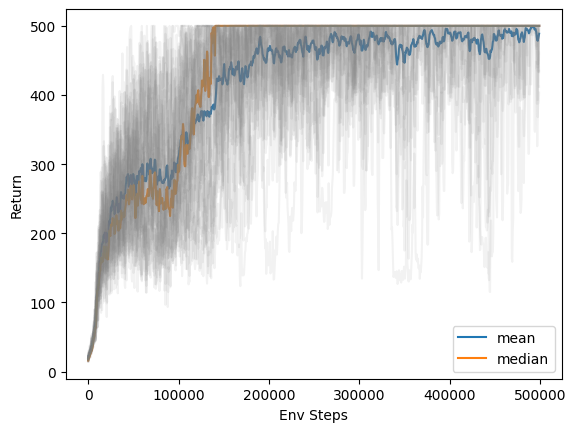

In [3]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import gymnax
from wrappers import LogWrapper, FlattenObservationWrapper


class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)


class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray


def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    env, env_params = gymnax.make(config["ENV_NAME"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)

    def linear_schedule(count):
        frac = (
            1.0
            - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"]))
            / config["NUM_UPDATES"]
        )
        return config["LR"] * frac

    def train(rng):
        # INIT NETWORK
        network = ActorCritic(
            env.action_space(env_params).n, activation=config["ACTIVATION"]
        )
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                pi, value = network.apply(train_state.params, last_obs)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(
                    env.step, in_axes=(0, 0, 0, None)
                )(rng_step, env_state, action, env_params)
                transition = Transition(
                    done, action, value, reward, log_prob, last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            _, last_val = network.apply(train_state.params, last_obs)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_batch(update_state, _):
                train_state, traj_batch, advantages, targets, rng = update_state
                batch = (traj_batch, advantages, targets)

                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                bs = config["MINIBATCH_SIZE"]
                
                batch = jax.tree_util.tree_map( lambda x: x.reshape((batch_size,) + x.shape[2:]), batch )
                rng, _rng = jax.random.split(rng)
                permutation = jax.random.permutation(_rng, batch_size)
                batch = jax.tree_util.tree_map( lambda x: jnp.take(x, permutation, axis=0), batch )
                batch = jax.tree_util.tree_map( lambda x: x[:bs], batch )
                batch_main, batch_adv, batch_target = batch
                
                def _loss_fn(params, traj_batch, gae, targets):
                    # RERUN NETWORK
                    pi, value = network.apply(params, traj_batch.obs)
                    log_prob = pi.log_prob(traj_batch.action)

                    # CALCULATE VALUE LOSS
                    value_pred_clipped = traj_batch.value + (
                        value - traj_batch.value
                    ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                    value_losses = jnp.square(value - targets)
                    value_losses_clipped = jnp.square(value_pred_clipped - targets)
                    value_loss = (
                        0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                    )

                    # CALCULATE ACTOR LOSS
                    ratio = jnp.exp(log_prob - traj_batch.log_prob)
                    gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                    loss_actor1 = ratio * gae
                    loss_actor2 = (
                        jnp.clip(
                            ratio,
                            1.0 - config["CLIP_EPS"],
                            1.0 + config["CLIP_EPS"],
                        )
                        * gae
                    )
                    loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                    loss_actor = loss_actor.mean()
                    entropy = pi.entropy().mean()

                    total_loss = (
                        loss_actor
                        + config["VF_COEF"] * value_loss
                        - config["ENT_COEF"] * entropy
                    )
                    return total_loss, (value_loss, loss_actor, entropy)

                grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                total_loss, grads = grad_fn( train_state.params, batch_main, batch_adv, batch_target )
                train_state = train_state.apply_gradients(grads=grads)

                update_state = train_state, traj_batch, advantages, targets, rng
                return update_state, total_loss


            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan( _update_batch, update_state, None, config["UPDATE_EPOCHS"]*config["NUM_MINIBATCHES"] )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]
            if config.get("DEBUG"):
                def callback(info):
                    return_values = info["returned_episode_returns"][info["returned_episode"]]
                    timesteps = info["timestep"][info["returned_episode"]] * config["NUM_ENVS"]
                    for t in range(len(timesteps)):
                        print(f"global step={timesteps[t]}, episodic return={return_values[t]}")
                jax.debug.callback(callback, metric)

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train


if __name__ == "__main__":
    config = {
        "LR": 2.5e-4,
        "NUM_ENVS": 4,
        "NUM_STEPS": 128,
        "TOTAL_TIMESTEPS": 5e5,
        "UPDATE_EPOCHS": 4,
        "NUM_MINIBATCHES": 4,
        "GAMMA": 0.99,
        "GAE_LAMBDA": 0.95,
        "CLIP_EPS": 0.2,
        "ENT_COEF": 0.01,
        "VF_COEF": 0.5,
        "MAX_GRAD_NORM": 0.5,
        "ACTIVATION": "tanh",
        "ENV_NAME": "CartPole-v1",
        "ANNEAL_LR": False,
        "DEBUG": False,
    }
    rng = jax.random.PRNGKey(30)
    train_fn = jax.jit(jax.vmap(make_train(config)))
    rng, *_rng = jax.random.split(rng, 1+32)
    out = train_fn(jnp.stack(_rng))
    metrics = out["metrics"]
    print(jax.tree_map(lambda x: x.shape, metrics))
    rets = metrics["returned_episode_returns"]  # n_seed, n_iters, n_steps, n_envs
    import matplotlib.pyplot as plt
    n_iters = rets.shape[1]
    steps = jnp.arange(n_iters) * config["NUM_STEPS"] * config["NUM_ENVS"]
    plt.plot(steps, jnp.mean(rets, axis=(0, 2, 3)), label='mean')
    plt.plot(steps, jnp.median(rets, axis=(0, 2, 3)), label='median')
    plt.plot(steps, jnp.mean(rets, axis=(2, 3)).T, c='gray', alpha=0.1)
    plt.legend()
    plt.ylabel('Return')
    plt.xlabel('Env Steps')
    plt.show()
    


# BATCHES OVER ENVS ONLY

{'discount': (32, 976, 128, 4), 'returned_episode': (32, 976, 128, 4), 'returned_episode_lengths': (32, 976, 128, 4), 'returned_episode_returns': (32, 976, 128, 4), 'timestep': (32, 976, 128, 4)}


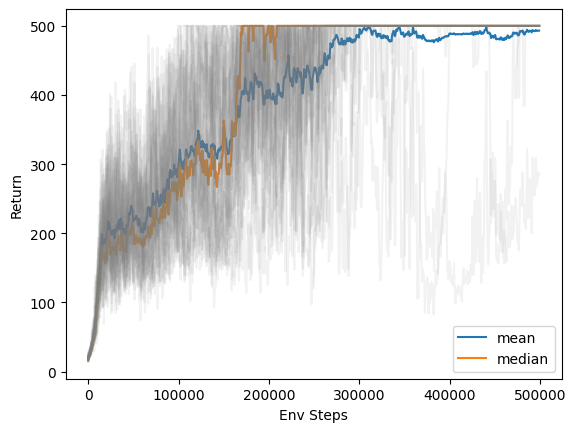

In [4]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import gymnax
from wrappers import LogWrapper, FlattenObservationWrapper
from einops import rearrange


class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)


class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray


def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    env, env_params = gymnax.make(config["ENV_NAME"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)

    def linear_schedule(count):
        frac = (
            1.0
            - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"]))
            / config["NUM_UPDATES"]
        )
        return config["LR"] * frac

    def train(rng):
        # INIT NETWORK
        network = ActorCritic(
            env.action_space(env_params).n, activation=config["ACTIVATION"]
        )
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                pi, value = network.apply(train_state.params, last_obs)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(
                    env.step, in_axes=(0, 0, 0, None)
                )(rng_step, env_state, action, env_params)
                transition = Transition(
                    done, action, value, reward, log_prob, last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            _, last_val = network.apply(train_state.params, last_obs)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_batch(update_state, _):
                train_state, traj_batch, advantages, targets, rng = update_state
                batch = (traj_batch, advantages, targets)

                rng, _rng = jax.random.split(rng)
                n_envs_batch = config["NUM_ENVS"]//config["NUM_MINIBATCHES"]
                idx_env = jax.random.permutation(_rng, config["NUM_ENVS"])[:n_envs_batch]
                batch = jax.tree_util.tree_map( lambda x: x[:, idx_env], batch )
                batch = jax.tree_util.tree_map( lambda x: rearrange(x, 't n ... -> (t n) ...'), batch )
                batch_main, batch_adv, batch_target = batch
                
                def _loss_fn(params, traj_batch, gae, targets):
                    # RERUN NETWORK
                    pi, value = network.apply(params, traj_batch.obs)
                    log_prob = pi.log_prob(traj_batch.action)

                    # CALCULATE VALUE LOSS
                    value_pred_clipped = traj_batch.value + (
                        value - traj_batch.value
                    ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                    value_losses = jnp.square(value - targets)
                    value_losses_clipped = jnp.square(value_pred_clipped - targets)
                    value_loss = (
                        0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                    )

                    # CALCULATE ACTOR LOSS
                    ratio = jnp.exp(log_prob - traj_batch.log_prob)
                    gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                    loss_actor1 = ratio * gae
                    loss_actor2 = (
                        jnp.clip(
                            ratio,
                            1.0 - config["CLIP_EPS"],
                            1.0 + config["CLIP_EPS"],
                        )
                        * gae
                    )
                    loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                    loss_actor = loss_actor.mean()
                    entropy = pi.entropy().mean()

                    total_loss = (
                        loss_actor
                        + config["VF_COEF"] * value_loss
                        - config["ENT_COEF"] * entropy
                    )
                    return total_loss, (value_loss, loss_actor, entropy)

                grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                total_loss, grads = grad_fn( train_state.params, batch_main, batch_adv, batch_target )
                train_state = train_state.apply_gradients(grads=grads)

                update_state = train_state, traj_batch, advantages, targets, rng
                return update_state, total_loss


            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan( _update_batch, update_state, None, config["UPDATE_EPOCHS"]*config["NUM_MINIBATCHES"] )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]
            if config.get("DEBUG"):
                def callback(info):
                    return_values = info["returned_episode_returns"][info["returned_episode"]]
                    timesteps = info["timestep"][info["returned_episode"]] * config["NUM_ENVS"]
                    for t in range(len(timesteps)):
                        print(f"global step={timesteps[t]}, episodic return={return_values[t]}")
                jax.debug.callback(callback, metric)

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train


if __name__ == "__main__":
    config = {
        "LR": 2.5e-4,
        "NUM_ENVS": 4,
        "NUM_STEPS": 128,
        "TOTAL_TIMESTEPS": 5e5,
        "UPDATE_EPOCHS": 4,
        "NUM_MINIBATCHES": 4,
        "GAMMA": 0.99,
        "GAE_LAMBDA": 0.95,
        "CLIP_EPS": 0.2,
        "ENT_COEF": 0.01,
        "VF_COEF": 0.5,
        "MAX_GRAD_NORM": 0.5,
        "ACTIVATION": "tanh",
        "ENV_NAME": "CartPole-v1",
        "ANNEAL_LR": False,
        "DEBUG": False,
    }
    rng = jax.random.PRNGKey(30)
    train_fn = jax.jit(jax.vmap(make_train(config)))
    rng, *_rng = jax.random.split(rng, 1+32)
    out = train_fn(jnp.stack(_rng))
    metrics = out["metrics"]
    print(jax.tree_map(lambda x: x.shape, metrics))
    rets = metrics["returned_episode_returns"]  # n_seed, n_iters, n_steps, n_envs
    import matplotlib.pyplot as plt
    n_iters = rets.shape[1]
    steps = jnp.arange(n_iters) * config["NUM_STEPS"] * config["NUM_ENVS"]
    plt.plot(steps, jnp.mean(rets, axis=(0, 2, 3)), label='mean')
    plt.plot(steps, jnp.median(rets, axis=(0, 2, 3)), label='median')
    plt.plot(steps, jnp.mean(rets, axis=(2, 3)).T, c='gray', alpha=0.1)
    plt.legend()
    plt.ylabel('Return')
    plt.xlabel('Env Steps')
    plt.show()
    


# CHANGE FROM COMPACT TO SETUP (Flax)

{'discount': (32, 976, 128, 4), 'returned_episode': (32, 976, 128, 4), 'returned_episode_lengths': (32, 976, 128, 4), 'returned_episode_returns': (32, 976, 128, 4), 'timestep': (32, 976, 128, 4)}


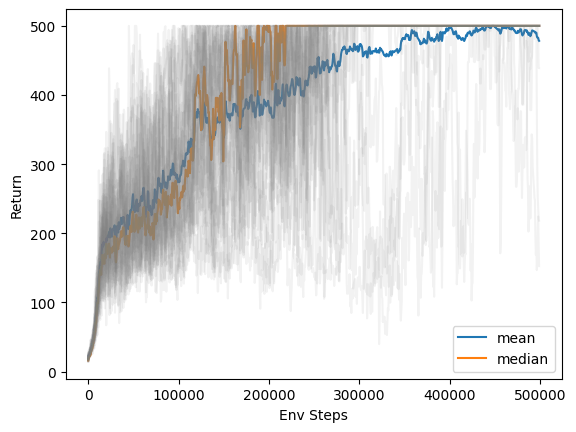

In [5]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import gymnax
from wrappers import LogWrapper, FlattenObservationWrapper
from einops import rearrange


class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    def setup(self):
        activation = nn.relu if self.activation == "relu" else nn.tanh
        self.seq_pi = nn.Sequential([
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense( self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0) ),
        ])

        self.seq_critic = nn.Sequential([
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0)),
        ])

    def __call__(self, x):
        logits = self.seq_pi(x)
        val = self.seq_critic(x)
        pi = distrax.Categorical(logits=logits)
        return pi, val[..., 0]


class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray


def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    env, env_params = gymnax.make(config["ENV_NAME"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)

    def linear_schedule(count):
        frac = (
            1.0
            - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"]))
            / config["NUM_UPDATES"]
        )
        return config["LR"] * frac

    def train(rng):
        # INIT NETWORK
        network = ActorCritic(
            env.action_space(env_params).n, activation=config["ACTIVATION"]
        )
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                pi, value = network.apply(train_state.params, last_obs)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(
                    env.step, in_axes=(0, 0, 0, None)
                )(rng_step, env_state, action, env_params)
                transition = Transition(
                    done, action, value, reward, log_prob, last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            _, last_val = network.apply(train_state.params, last_obs)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_batch(update_state, _):
                train_state, traj_batch, advantages, targets, rng = update_state
                batch = (traj_batch, advantages, targets)

                rng, _rng = jax.random.split(rng)
                n_envs_batch = config["NUM_ENVS"]//config["NUM_MINIBATCHES"]
                idx_env = jax.random.permutation(_rng, config["NUM_ENVS"])[:n_envs_batch]
                batch = jax.tree_util.tree_map( lambda x: x[:, idx_env], batch )
                batch = jax.tree_util.tree_map( lambda x: rearrange(x, 't n ... -> (t n) ...'), batch )
                batch_main, batch_adv, batch_target = batch
                
                def _loss_fn(params, traj_batch, gae, targets):
                    # RERUN NETWORK
                    pi, value = network.apply(params, traj_batch.obs)
                    log_prob = pi.log_prob(traj_batch.action)

                    # CALCULATE VALUE LOSS
                    value_pred_clipped = traj_batch.value + (
                        value - traj_batch.value
                    ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                    value_losses = jnp.square(value - targets)
                    value_losses_clipped = jnp.square(value_pred_clipped - targets)
                    value_loss = (
                        0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                    )

                    # CALCULATE ACTOR LOSS
                    ratio = jnp.exp(log_prob - traj_batch.log_prob)
                    gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                    loss_actor1 = ratio * gae
                    loss_actor2 = (
                        jnp.clip(
                            ratio,
                            1.0 - config["CLIP_EPS"],
                            1.0 + config["CLIP_EPS"],
                        )
                        * gae
                    )
                    loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                    loss_actor = loss_actor.mean()
                    entropy = pi.entropy().mean()

                    total_loss = (
                        loss_actor
                        + config["VF_COEF"] * value_loss
                        - config["ENT_COEF"] * entropy
                    )
                    return total_loss, (value_loss, loss_actor, entropy)

                grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                total_loss, grads = grad_fn( train_state.params, batch_main, batch_adv, batch_target )
                train_state = train_state.apply_gradients(grads=grads)

                update_state = train_state, traj_batch, advantages, targets, rng
                return update_state, total_loss


            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan( _update_batch, update_state, None, config["UPDATE_EPOCHS"]*config["NUM_MINIBATCHES"] )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]
            if config.get("DEBUG"):
                def callback(info):
                    return_values = info["returned_episode_returns"][info["returned_episode"]]
                    timesteps = info["timestep"][info["returned_episode"]] * config["NUM_ENVS"]
                    for t in range(len(timesteps)):
                        print(f"global step={timesteps[t]}, episodic return={return_values[t]}")
                jax.debug.callback(callback, metric)

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train


if __name__ == "__main__":
    config = {
        "LR": 2.5e-4,
        "NUM_ENVS": 4,
        "NUM_STEPS": 128,
        "TOTAL_TIMESTEPS": 5e5,
        "UPDATE_EPOCHS": 4,
        "NUM_MINIBATCHES": 4,
        "GAMMA": 0.99,
        "GAE_LAMBDA": 0.95,
        "CLIP_EPS": 0.2,
        "ENT_COEF": 0.01,
        "VF_COEF": 0.5,
        "MAX_GRAD_NORM": 0.5,
        "ACTIVATION": "tanh",
        "ENV_NAME": "CartPole-v1",
        "ANNEAL_LR": False,
        "DEBUG": False,
    }
    rng = jax.random.PRNGKey(30)
    train_fn = jax.jit(jax.vmap(make_train(config)))
    rng, *_rng = jax.random.split(rng, 1+32)
    out = train_fn(jnp.stack(_rng))
    metrics = out["metrics"]
    print(jax.tree_map(lambda x: x.shape, metrics))
    rets = metrics["returned_episode_returns"]  # n_seed, n_iters, n_steps, n_envs
    import matplotlib.pyplot as plt
    n_iters = rets.shape[1]
    steps = jnp.arange(n_iters) * config["NUM_STEPS"] * config["NUM_ENVS"]
    plt.plot(steps, jnp.mean(rets, axis=(0, 2, 3)), label='mean')
    plt.plot(steps, jnp.median(rets, axis=(0, 2, 3)), label='median')
    plt.plot(steps, jnp.mean(rets, axis=(2, 3)).T, c='gray', alpha=0.1)
    plt.legend()
    plt.ylabel('Return')
    plt.xlabel('Env Steps')
    plt.show()
    


# CLEANUP + MAKE RECURRENT

{'discount': (32, 976, 128, 4), 'returned_episode': (32, 976, 128, 4), 'returned_episode_lengths': (32, 976, 128, 4), 'returned_episode_returns': (32, 976, 128, 4), 'timestep': (32, 976, 128, 4)}


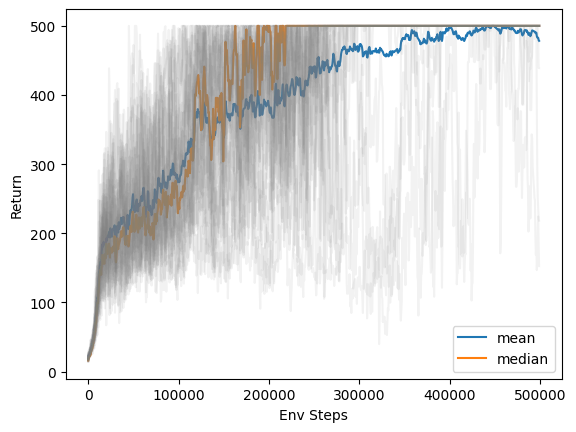

In [6]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import gymnax
from wrappers import LogWrapper, FlattenObservationWrapper
from einops import rearrange
from functools import partial


class ActorCritic(nn.Module):
    n_acts: Sequence[int]
    activation: str = "tanh"

    def setup(self):
        activation = nn.relu if self.activation == "relu" else nn.tanh
        self.seq_pi = nn.Sequential([
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense( self.n_acts, kernel_init=orthogonal(0.01), bias_init=constant(0.0) )
        ])
        self.seq_critic = nn.Sequential([
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0)),
        ])

    def get_init_state(self, rng):
        return None

    def forward_recurrent(self, state, oar): # shape: (...)
        obs, act_p, rew_p = oar
        logits = self.seq_pi(obs)
        val = self.seq_critic(obs)
        # pi = distrax.Categorical(logits=logits)
        # return state, (pi, val[..., 0])
        return state, (logits, val[..., 0])

    def forward_parallel(self, obs, act_p, rew_p): # shape: (n_steps, ...)
        logits = self.seq_pi(obs)
        val = self.seq_critic(obs)
        # pi = distrax.Categorical(logits=logits)
        return logits, val[..., 0]


def make_train(config):
    config["NUM_UPDATES"] = ( config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"] )
    config["MINIBATCH_SIZE"] = ( config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"] )
    env, env_params = gymnax.make(config["ENV_NAME"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)

    def linear_schedule(count):
        frac = ( 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"] )
        return config["LR"] * frac

    def train(rng):
        # INIT NETWORK
        network = ActorCritic( env.action_space(env_params).n, activation=config["ACTIVATION"] )
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, None, (init_x, None, None), method=network.forward_recurrent)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )
        train_state = TrainState.create( apply_fn=network.apply, params=network_params, tx=tx, )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        _rng = jax.random.split(_rng, config["NUM_ENVS"])
        obs, env_state = jax.vmap(env.reset, in_axes=(0, None))(_rng, env_params)
        act_p, rew_p = jnp.zeros(config["NUM_ENVS"], dtype=jnp.int32), jnp.zeros(config["NUM_ENVS"])
        oar = obs, act_p, rew_p
        
        # rng, _rng = jax.random.split(rng)
        # _rng = jax.random.split(_rng, config["NUM_ENVS"])
        agent_init_state = jax.vmap(network.get_init_state)(_rng)

        forward_recurrent = jax.vmap(partial(network.apply, method=network.forward_recurrent),
                                     in_axes=(None, 0, (0, 0, 0)))
        forward_parallel = jax.vmap(partial(network.apply, method=network.forward_parallel),
                                    in_axes=(None, 0, 0, 0))

        # TRAIN LOOP
        def _update_step(runner_state, _):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, _):
                train_state, env_state, agent_state, (obs, act_p, rew_p), rng = runner_state

                # SELECT ACTION
                # agent_state_n, (logits, value) = network.apply(train_state.params, agent_state,
                #                                          (obs, act_p, rew_p),
                #                                          method=network.forward_recurrent)
                agent_state_n, (logits, value) = forward_recurrent(train_state.params,
                                                                   agent_state, (obs, act_p, rew_p))
                rng, _rng = jax.random.split(rng)
                pi = distrax.Categorical(logits=logits)
                act = pi.sample(seed=_rng)
                log_prob = pi.log_prob(act)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                _rng = jax.random.split(_rng, config["NUM_ENVS"])
                obs_n, env_state_n, rew, done, info = jax.vmap( env.step, in_axes=(0, 0, 0, None) )(_rng, env_state, act, env_params)
                runner_state = (train_state, env_state_n, agent_state_n, (obs_n, act, rew), rng)
                transition = dict(obs=obs, act=act, rew=rew, done=done, info=info,
                                  act_p=act_p, rew_p=rew_p,
                                  logits=logits, log_prob=log_prob, val=value)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan( _env_step, runner_state, None, config["NUM_STEPS"] )

            # CALCULATE ADVANTAGE
            train_state, env_state, agent_state, (obs, act_p, rew_p), rng = runner_state
            # _, (_, last_val) = network.apply(train_state.params, agent_state, (obs, act_p, rew_p),
            #                                method=network.forward_recurrent)
            _, (_, last_val) = forward_recurrent(train_state.params, agent_state, (obs, act_p, rew_p))
            # last_val = traj_batch['val'][-1]

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = transition["done"], transition["val"], transition["rew"]
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = ( delta + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae )
                    return (gae, value), gae

                _, advantages = jax.lax.scan( _get_advantages, (jnp.zeros_like(last_val), last_val),
                    traj_batch, reverse=True, unroll=16, )
                return advantages, advantages + traj_batch['val']

            traj_batch['adv'], traj_batch['ret'] = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_batch(update_state, _):
                train_state, traj_batch, rng = update_state
                batch = traj_batch

                rng, _rng = jax.random.split(rng)
                n_envs_batch = config["NUM_ENVS"]//config["NUM_MINIBATCHES"]
                idx_env = jax.random.permutation(_rng, config["NUM_ENVS"])[:n_envs_batch]
                batch = jax.tree_util.tree_map( lambda x: x[:, idx_env], batch )
                # batch = jax.tree_util.tree_map( lambda x: rearrange(x, 't n ... -> (t n) ...'), batch )
                batch = jax.tree_util.tree_map( lambda x: rearrange(x, 't n ... -> n t ...'), batch )
                
                def _loss_fn(params, batch):
                    
                    # RERUN NETWORK
                    # logits, value = network.apply(params, batch['obs'], batch['act_p'], batch['rew_p'],
                    #                               method=network.forward_parallel)
                    logits, value = forward_parallel(params, batch['obs'], batch['act_p'], batch['rew_p'])
                    pi = distrax.Categorical(logits=logits)
                    log_prob = pi.log_prob(batch['act'])

                    # CALCULATE VALUE LOSS
                    value_pred_clipped = batch['val'] + ( value - batch['val'] ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                    value_losses = jnp.square(value - batch['ret'])
                    value_losses_clipped = jnp.square(value_pred_clipped - batch['ret'])
                    value_loss = ( 0.5 * jnp.maximum(value_losses, value_losses_clipped).mean() )

                    # CALCULATE ACTOR LOSS
                    ratio = jnp.exp(log_prob - batch['log_prob'])
                    gae = batch['adv']
                    gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                    loss_actor1 = ratio * gae
                    loss_actor2 = ( jnp.clip( ratio, 1.0 - config["CLIP_EPS"], 1.0 + config["CLIP_EPS"], ) * gae )
                    loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                    loss_actor = loss_actor.mean()
                    entropy = pi.entropy().mean()

                    total_loss = ( loss_actor + config["VF_COEF"] * value_loss - config["ENT_COEF"] * entropy )
                    return total_loss, (value_loss, loss_actor, entropy)

                grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                total_loss, grads = grad_fn( train_state.params, batch)
                train_state = train_state.apply_gradients(grads=grads)

                update_state = train_state, traj_batch, rng
                return update_state, total_loss

            update_state = (train_state, traj_batch, rng)
            update_state, loss_info = jax.lax.scan( _update_batch, update_state, None, config["UPDATE_EPOCHS"]*config["NUM_MINIBATCHES"] )
            train_state = update_state[0]
            metric = traj_batch['info']
            rng = update_state[-1]
            if config.get("DEBUG"):
                def callback(info):
                    return_values = info["returned_episode_returns"][info["returned_episode"]]
                    timesteps = info["timestep"][info["returned_episode"]] * config["NUM_ENVS"]
                    for t in range(len(timesteps)):
                        print(f"global step={timesteps[t]}, episodic return={return_values[t]}")
                jax.debug.callback(callback, metric)

            runner_state = (train_state, env_state, agent_state, (obs, act_p, rew_p), rng)
            return runner_state, metric

        agent_state = jax.tree_map(lambda x: x, agent_init_state)  # copy
        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, agent_state, oar, _rng)
        runner_state, metric = jax.lax.scan( _update_step, runner_state, None, config["NUM_UPDATES"] )
        return {"runner_state": runner_state, "metrics": metric}

    return train


if __name__ == "__main__":
    config = {
        "LR": 2.5e-4,
        "NUM_ENVS": 4,
        "NUM_STEPS": 128,
        "TOTAL_TIMESTEPS": 5e5,
        "UPDATE_EPOCHS": 4,
        "NUM_MINIBATCHES": 4,
        "GAMMA": 0.99,
        "GAE_LAMBDA": 0.95,
        "CLIP_EPS": 0.2,
        "ENT_COEF": 0.01,
        "VF_COEF": 0.5,
        "MAX_GRAD_NORM": 0.5,
        "ACTIVATION": "tanh",
        "ENV_NAME": "CartPole-v1",
        "ANNEAL_LR": False,
        "DEBUG": False,
    }
    rng = jax.random.PRNGKey(30)
    train_fn = jax.jit(jax.vmap(make_train(config)))
    rng, *_rng = jax.random.split(rng, 1+32)
    out = train_fn(jnp.stack(_rng))
    metrics = out["metrics"]
    print(jax.tree_map(lambda x: x.shape, metrics))
    rets = metrics["returned_episode_returns"]  # n_seed, n_iters, n_steps, n_envs
    import matplotlib.pyplot as plt
    n_iters = rets.shape[1]
    steps = jnp.arange(n_iters) * config["NUM_STEPS"] * config["NUM_ENVS"]
    plt.plot(steps, jnp.mean(rets, axis=(0, 2, 3)), label='mean')
    plt.plot(steps, jnp.median(rets, axis=(0, 2, 3)), label='median')
    plt.plot(steps, jnp.mean(rets, axis=(2, 3)).T, c='gray', alpha=0.1)
    plt.legend()
    plt.ylabel('Return')
    plt.xlabel('Env Steps')
    plt.show()
    


# Get rid of obs, act_p, rew and replace with just obs

{'discount': (32, 976, 128, 4), 'returned_episode': (32, 976, 128, 4), 'returned_episode_lengths': (32, 976, 128, 4), 'returned_episode_returns': (32, 976, 128, 4), 'timestep': (32, 976, 128, 4)}


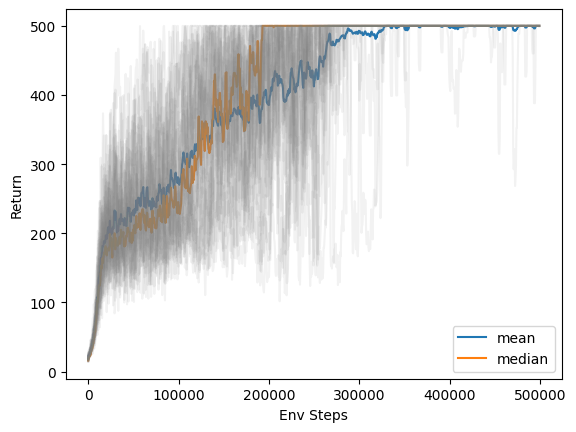

In [52]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence
from flax.training.train_state import TrainState
import distrax
import gymnax
from wrappers import LogWrapper, FlattenObservationWrapper
from einops import rearrange
from functools import partial


class ActorCritic(nn.Module):
    n_acts: Sequence[int]
    activation: str = "tanh"

    def setup(self):
        activation = nn.relu if self.activation == "relu" else nn.tanh
        self.seq_pi = nn.Sequential([
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense( self.n_acts, kernel_init=orthogonal(0.01), bias_init=constant(0.0) )
        ])
        self.seq_critic = nn.Sequential([
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0)),
        ])

    def get_init_state(self, rng):
        return None

    def forward_recurrent(self, state, obs): # shape: (...)
        logits = self.seq_pi(obs)
        val = self.seq_critic(obs)
        # pi = distrax.Categorical(logits=logits)
        # return state, (pi, val[..., 0])
        return state, (logits, val[..., 0])

    def forward_parallel(self, obs): # shape: (n_steps, ...)
        logits = self.seq_pi(obs)
        val = self.seq_critic(obs)
        # pi = distrax.Categorical(logits=logits)
        return logits, val[..., 0]


def make_train(config):
    config["NUM_UPDATES"] = ( config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"] )
    config["MINIBATCH_SIZE"] = ( config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"] )
    env, env_params = gymnax.make(config["ENV_NAME"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)

    def train(rng):
        # INIT NETWORK
        network = ActorCritic( env.action_space(env_params).n, activation=config["ACTIVATION"] )
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, None, init_x, method=network.forward_recurrent)
        tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))
        train_state = TrainState.create( apply_fn=network.apply, params=network_params, tx=tx, )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        _rng = jax.random.split(_rng, config["NUM_ENVS"])
        obs, env_state = jax.vmap(env.reset, in_axes=(0, None))(_rng, env_params)
        
        # rng, _rng = jax.random.split(rng)
        # _rng = jax.random.split(_rng, config["NUM_ENVS"])
        agent_init_state = jax.vmap(network.get_init_state)(_rng)

        forward_recurrent = jax.vmap(partial(network.apply, method=network.forward_recurrent),
                                     in_axes=(None, 0, 0))
        forward_parallel = jax.vmap(partial(network.apply, method=network.forward_parallel),
                                    in_axes=(None, 0))

        # TRAIN LOOP
        def _update_step(runner_state, _):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, _):
                train_state, env_state, agent_state, obs, rng = runner_state

                # SELECT ACTION
                # agent_state_n, (logits, value) = network.apply(train_state.params, agent_state,
                #                                          (obs, act_p, rew_p),
                #                                          method=network.forward_recurrent)
                agent_state_n, (logits, value) = forward_recurrent(train_state.params,
                                                                   agent_state, obs)
                rng, _rng = jax.random.split(rng)
                pi = distrax.Categorical(logits=logits)
                act = pi.sample(seed=_rng)
                log_prob = pi.log_prob(act)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                _rng = jax.random.split(_rng, config["NUM_ENVS"])
                obs_n, env_state_n, rew, done, info = jax.vmap( env.step, in_axes=(0, 0, 0, None) )(_rng, env_state, act, env_params)
                runner_state = (train_state, env_state_n, agent_state_n, obs_n, rng)
                transition = dict(obs=obs, act=act, rew=rew, done=done, info=info,
                                  logits=logits, log_prob=log_prob, val=value)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(_env_step, runner_state, None, config["NUM_STEPS"] )

            # CALCULATE ADVANTAGE
            train_state, env_state, agent_state, obs, rng = runner_state
            # _, (_, last_val) = network.apply(train_state.params, agent_state, (obs, act_p, rew_p),
            #                                method=network.forward_recurrent)
            _, (_, last_val) = forward_recurrent(train_state.params, agent_state, obs)
            # last_val = traj_batch['val'][-1]

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = transition["done"], transition["val"], transition["rew"]
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = ( delta + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae )
                    return (gae, value), gae

                _, advantages = jax.lax.scan( _get_advantages, (jnp.zeros_like(last_val), last_val),
                    traj_batch, reverse=True, unroll=16, )
                return advantages, advantages + traj_batch['val']

            traj_batch['adv'], traj_batch['ret'] = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_batch(update_state, _):
                train_state, traj_batch, rng = update_state
                batch = traj_batch

                rng, _rng = jax.random.split(rng)
                n_envs_batch = config["NUM_ENVS"]//config["NUM_MINIBATCHES"]
                idx_env = jax.random.permutation(_rng, config["NUM_ENVS"])[:n_envs_batch]
                batch = jax.tree_util.tree_map( lambda x: x[:, idx_env], batch )
                # batch = jax.tree_util.tree_map( lambda x: rearrange(x, 't n ... -> (t n) ...'), batch )
                batch = jax.tree_util.tree_map( lambda x: rearrange(x, 't n ... -> n t ...'), batch )
                
                def _loss_fn(params, batch):
                    
                    # RERUN NETWORK
                    # logits, value = network.apply(params, batch['obs'], batch['act_p'], batch['rew_p'],
                    #                               method=network.forward_parallel)
                    logits, value = forward_parallel(params, batch['obs'])
                    pi = distrax.Categorical(logits=logits)
                    log_prob = pi.log_prob(batch['act'])

                    # CALCULATE VALUE LOSS
                    value_pred_clipped = batch['val'] + ( value - batch['val'] ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                    value_losses = jnp.square(value - batch['ret'])
                    value_losses_clipped = jnp.square(value_pred_clipped - batch['ret'])
                    value_loss = ( 0.5 * jnp.maximum(value_losses, value_losses_clipped).mean() )

                    # CALCULATE ACTOR LOSS
                    ratio = jnp.exp(log_prob - batch['log_prob'])
                    gae = batch['adv']
                    gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                    loss_actor1 = ratio * gae
                    loss_actor2 = ( jnp.clip( ratio, 1.0 - config["CLIP_EPS"], 1.0 + config["CLIP_EPS"], ) * gae )
                    loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                    loss_actor = loss_actor.mean()
                    entropy = pi.entropy().mean()

                    total_loss = ( loss_actor + config["VF_COEF"] * value_loss - config["ENT_COEF"] * entropy )
                    return total_loss, (value_loss, loss_actor, entropy)

                grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                total_loss, grads = grad_fn( train_state.params, batch)
                train_state = train_state.apply_gradients(grads=grads)

                update_state = train_state, traj_batch, rng
                return update_state, total_loss

            update_state = (train_state, traj_batch, rng)
            update_state, loss_info = jax.lax.scan( _update_batch, update_state, None, config["UPDATE_EPOCHS"]*config["NUM_MINIBATCHES"] )
            train_state = update_state[0]
            metric = traj_batch['info']
            rng = update_state[-1]
            if config.get("DEBUG"):
                def callback(info):
                    return_values = info["returned_episode_returns"][info["returned_episode"]]
                    timesteps = info["timestep"][info["returned_episode"]] * config["NUM_ENVS"]
                    for t in range(len(timesteps)):
                        print(f"global step={timesteps[t]}, episodic return={return_values[t]}")
                jax.debug.callback(callback, metric)

            runner_state = (train_state, env_state, agent_state, obs, rng)
            return runner_state, metric

        agent_state = jax.tree_map(lambda x: x, agent_init_state)  # copy
        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, agent_state, obs, _rng)
        runner_state, metric = jax.lax.scan( _update_step, runner_state, None, config["NUM_UPDATES"] )
        return {"runner_state": runner_state, "metrics": metric}

    return train


if __name__ == "__main__":
    config = {
        "LR": 2.5e-4,
        "NUM_ENVS": 4,
        "NUM_STEPS": 128,
        "TOTAL_TIMESTEPS": 5e5,
        "UPDATE_EPOCHS": 4,
        "NUM_MINIBATCHES": 4,
        "GAMMA": 0.99,
        "GAE_LAMBDA": 0.95,
        "CLIP_EPS": 0.2,
        "ENT_COEF": 0.01,
        "VF_COEF": 0.5,
        "MAX_GRAD_NORM": 0.5,
        "ACTIVATION": "tanh",
        "ENV_NAME": "CartPole-v1",
        "ANNEAL_LR": False,
        "DEBUG": False,
    }
    rng = jax.random.PRNGKey(30)
    train_fn = jax.jit(jax.vmap(make_train(config)))
    rng, *_rng = jax.random.split(rng, 1+32)
    out = train_fn(jnp.stack(_rng))
    metrics = out["metrics"]
    print(jax.tree_map(lambda x: x.shape, metrics))
    rets = metrics["returned_episode_returns"]  # n_seed, n_iters, n_steps, n_envs
    import matplotlib.pyplot as plt
    n_iters = rets.shape[1]
    steps = jnp.arange(n_iters) * config["NUM_STEPS"] * config["NUM_ENVS"]
    plt.plot(steps, jnp.mean(rets, axis=(0, 2, 3)), label='mean')
    plt.plot(steps, jnp.median(rets, axis=(0, 2, 3)), label='median')
    plt.plot(steps, jnp.mean(rets, axis=(2, 3)).T, c='gray', alpha=0.1)
    plt.legend()
    plt.ylabel('Return')
    plt.xlabel('Env Steps')
    plt.show()
    


{'discount': (32, 976, 128, 4), 'returned_episode': (32, 976, 128, 4), 'returned_episode_lengths': (32, 976, 128, 4), 'returned_episode_returns': (32, 976, 128, 4), 'timestep': (32, 976, 128, 4)}


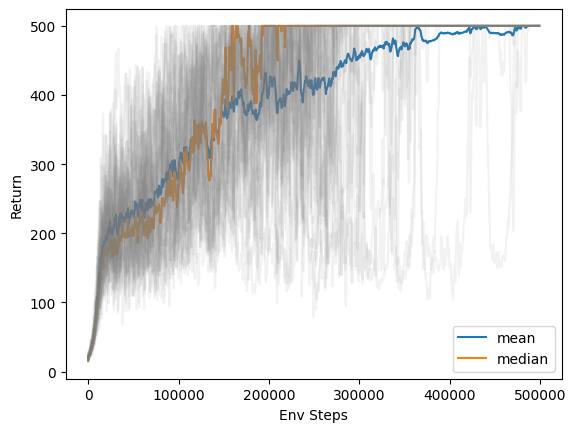

In [3]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence
from flax.training.train_state import TrainState
import distrax
import gymnax
from wrappers import LogWrapper, FlattenObservationWrapper
from einops import rearrange
from functools import partial


class ActorCritic(nn.Module):
    n_acts: Sequence[int]
    activation: str = "tanh"

    def setup(self):
        activation = nn.relu if self.activation == "relu" else nn.tanh
        self.seq_pi = nn.Sequential([
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense( self.n_acts, kernel_init=orthogonal(0.01), bias_init=constant(0.0) )
        ])
        self.seq_critic = nn.Sequential([
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0)),
        ])

    def get_init_state(self, rng):
        return None

    def forward_recurrent(self, state, obs): # shape: (...)
        logits = self.seq_pi(obs)
        val = self.seq_critic(obs)
        # pi = distrax.Categorical(logits=logits)
        # return state, (pi, val[..., 0])
        return state, (logits, val[..., 0])

    def forward_parallel(self, obs): # shape: (n_steps, ...)
        logits = self.seq_pi(obs)
        val = self.seq_critic(obs)
        # pi = distrax.Categorical(logits=logits)
        return logits, val[..., 0]


def make_train(config):
    config["NUM_UPDATES"] = ( config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"] )
    config["MINIBATCH_SIZE"] = ( config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"] )
    env, env_params = gymnax.make(config["ENV_NAME"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)
    
    network = ActorCritic( env.action_space(env_params).n, activation=config["ACTIVATION"] )
    
    def train(rng):
        forward_recurrent = jax.vmap(partial(network.apply, method=network.forward_recurrent),
                                     in_axes=(None, 0, 0))
        forward_parallel = jax.vmap(partial(network.apply, method=network.forward_parallel),
                                    in_axes=(None, 0))

        # TRAIN LOOP
        def _update_step(runner_state, _):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, _):
                train_state, env_state, agent_state, obs, rng = runner_state

                agent_state_n, (logits, value) = forward_recurrent(train_state.params, agent_state, obs)
                rng, _rng = jax.random.split(rng)
                pi = distrax.Categorical(logits=logits)
                act = pi.sample(seed=_rng)
                log_prob = pi.log_prob(act)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                _rng = jax.random.split(_rng, config["NUM_ENVS"])
                obs_n, env_state_n, rew, done, info = jax.vmap( env.step, in_axes=(0, 0, 0, None) )(_rng, env_state, act, env_params)
                runner_state = (train_state, env_state_n, agent_state_n, obs_n, rng)
                transition = dict(obs=obs, act=act, rew=rew, done=done, info=info,
                                  logits=logits, log_prob=log_prob, val=value)
                return runner_state, transition
            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = transition["done"], transition["val"], transition["rew"]
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = ( delta + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae )
                    return (gae, value), gae

                _, advantages = jax.lax.scan( _get_advantages, (jnp.zeros_like(last_val), last_val), traj_batch, reverse=True)
                return advantages, advantages + traj_batch['val']
            def _update_batch(update_state, _):
                train_state, traj_batch, rng = update_state
                batch = traj_batch

                rng, _rng = jax.random.split(rng)
                n_envs_batch = config["NUM_ENVS"]//config["NUM_MINIBATCHES"]
                idx_env = jax.random.permutation(_rng, config["NUM_ENVS"])[:n_envs_batch]
                batch = jax.tree_util.tree_map( lambda x: x[:, idx_env], batch )
                batch = jax.tree_util.tree_map( lambda x: rearrange(x, 't n ... -> n t ...'), batch )

                def _loss_fn(params, batch):
                    # RERUN NETWORK
                    logits, value = forward_parallel(params, batch['obs'])
                    pi = distrax.Categorical(logits=logits)
                    log_prob = pi.log_prob(batch['act'])

                    # CALCULATE VALUE LOSS
                    value_pred_clipped = batch['val'] + ( value - batch['val'] ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                    value_losses = jnp.square(value - batch['ret'])
                    value_losses_clipped = jnp.square(value_pred_clipped - batch['ret'])
                    value_loss = ( 0.5 * jnp.maximum(value_losses, value_losses_clipped).mean() )

                    # CALCULATE ACTOR LOSS
                    ratio = jnp.exp(log_prob - batch['log_prob'])
                    gae = batch['adv']
                    gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                    loss_actor1 = ratio * gae
                    loss_actor2 = ( jnp.clip( ratio, 1.0 - config["CLIP_EPS"], 1.0 + config["CLIP_EPS"], ) * gae )
                    loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                    loss_actor = loss_actor.mean()
                    entropy = pi.entropy().mean()

                    total_loss = ( loss_actor + config["VF_COEF"] * value_loss - config["ENT_COEF"] * entropy )
                    return total_loss, (value_loss, loss_actor, entropy)

                grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                total_loss, grads = grad_fn( train_state.params, batch)
                train_state = train_state.apply_gradients(grads=grads)

                update_state = train_state, traj_batch, rng
                return update_state, total_loss

            runner_state, traj_batch = jax.lax.scan(_env_step, runner_state, None, config["NUM_STEPS"] )

            # CALCULATE ADVANTAGE
            train_state, env_state, agent_state, obs, rng = runner_state
            last_val = traj_batch['val'][-1]
            traj_batch['adv'], traj_batch['ret'] = _calculate_gae(traj_batch, last_val)

            update_state = (train_state, traj_batch, rng)
            update_state, loss_info = jax.lax.scan( _update_batch, update_state, None, config["UPDATE_EPOCHS"]*config["NUM_MINIBATCHES"] )
            train_state = update_state[0]
            metric = traj_batch['info']
            rng = update_state[-1]
            runner_state = (train_state, env_state, agent_state, obs, rng)
            return runner_state, metric

        # INIT NETWORK
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, None, init_x, method=network.forward_recurrent)
        tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))
        train_state = TrainState.create( apply_fn=network.apply, params=network_params, tx=tx, )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        _rng = jax.random.split(_rng, config["NUM_ENVS"])
        obs, env_state = jax.vmap(env.reset, in_axes=(0, None))(_rng, env_params)

        # rng, _rng = jax.random.split(rng)
        # _rng = jax.random.split(_rng, config["NUM_ENVS"])
        agent_init_state = jax.vmap(network.get_init_state)(_rng)

        agent_state = jax.tree_map(lambda x: x, agent_init_state)  # copy
        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, agent_state, obs, _rng)
        runner_state, metric = jax.lax.scan( _update_step, runner_state, None, config["NUM_UPDATES"] )
        return {"runner_state": runner_state, "metrics": metric}

    return train


if __name__ == "__main__":
    config = {
        "LR": 2.5e-4,
        "NUM_ENVS": 4,
        "NUM_STEPS": 128,
        "TOTAL_TIMESTEPS": 5e5,
        "UPDATE_EPOCHS": 4,
        "NUM_MINIBATCHES": 4,
        "GAMMA": 0.99,
        "GAE_LAMBDA": 0.95,
        "CLIP_EPS": 0.2,
        "ENT_COEF": 0.01,
        "VF_COEF": 0.5,
        "MAX_GRAD_NORM": 0.5,
        "ACTIVATION": "tanh",
        "ENV_NAME": "CartPole-v1",
        "ANNEAL_LR": False,
        "DEBUG": False,
    }
    rng = jax.random.PRNGKey(30)
    train_fn = jax.jit(jax.vmap(make_train(config)))
    rng, *_rng = jax.random.split(rng, 1+32)
    out = train_fn(jnp.stack(_rng))
    metrics = out["metrics"]
    print(jax.tree_map(lambda x: x.shape, metrics))
    rets = metrics["returned_episode_returns"]  # n_seed, n_iters, n_steps, n_envs
    import matplotlib.pyplot as plt
    n_iters = rets.shape[1]
    steps = jnp.arange(n_iters) * config["NUM_STEPS"] * config["NUM_ENVS"]
    plt.plot(steps, jnp.mean(rets, axis=(0, 2, 3)), label='mean')
    plt.plot(steps, jnp.median(rets, axis=(0, 2, 3)), label='median')
    plt.plot(steps, jnp.mean(rets, axis=(2, 3)).T, c='gray', alpha=0.1)
    plt.legend()
    plt.ylabel('Return')
    plt.xlabel('Env Steps')
    plt.show()
    


hello
(32, 1000, 128, 4)


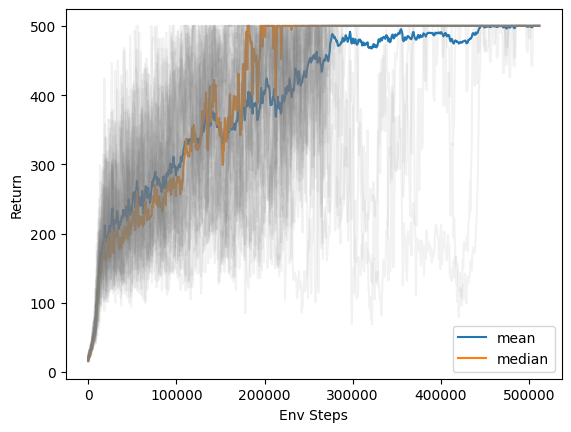

done


In [18]:
from jax.random import split

def calc_gae(buffer, val_last, gamma=0.99, gae_lambda=0.95):
    def calc_gae_step(carry, trans):
        gae, val_n = carry
        done, val, rew = trans["done"], trans["val"], trans["rew"]
        delta = rew + gamma * val_n * (1 - done) - val
        gae = delta + gamma * gae_lambda * (1 - done) * gae
        return (gae, val), gae
    carry = (jnp.zeros_like(val_last), val_last)
    _, adv = jax.lax.scan(calc_gae_step, carry, buffer, reverse=True)
    ret = adv + buffer['val']
    return adv, ret

def make_rollout_step_fn(agent, env, n_envs):
    def rollout_step(carry, _):
        rng, agent_params, env_params, agent_state, obs, env_state = carry
        # agent
        rng, _rng = split(rng)
        forward_recurrent = partial(agent.apply, method=agent.forward_recurrent)
        agent_state_n, (logits, val) = jax.vmap(forward_recurrent, in_axes=(None, 0, 0))(agent_params, agent_state, obs)
        pi = distrax.Categorical(logits=logits)
        act = pi.sample(seed=_rng)
        log_prob = pi.log_prob(act)
        # env
        rng, _rng = split(rng)
        obs_n, env_state_n, rew, done, info = jax.vmap(env.step, in_axes=(0, 0, 0, None))(split(_rng, n_envs), env_state, act, env_params)
        carry = rng, agent_params, env_params, agent_state_n, obs_n, env_state_n
        trans = dict(obs=obs, act=act, rew=rew, done=done, info=info, logits=logits, log_prob=log_prob, val=val)
        return carry, trans
    return rollout_step

def make_update_batch_fn(agent, n_envs, n_envs_batch, clip_eps, vf_coef, ent_coef):
    def _loss_fn(agent_params, batch):
        forward_parallel = partial(agent.apply, method=agent.forward_parallel)
        logits, val = jax.vmap(forward_parallel, in_axes=(None, 0))(agent_params, batch['obs'])
        pi = distrax.Categorical(logits=logits)
        log_prob = pi.log_prob(batch['act'])

        # value loss
        value_pred_clipped = batch['val'] + ( val - batch['val'] ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
        value_losses = jnp.square(val - batch['ret'])
        value_losses_clipped = jnp.square(value_pred_clipped - batch['ret'])
        value_loss = ( 0.5 * jnp.maximum(value_losses, value_losses_clipped).mean() )

        # policy loss
        ratio = jnp.exp(log_prob - batch['log_prob'])
        gae = batch['adv']
        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
        loss_actor1 = ratio * gae
        loss_actor2 = jnp.clip(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * gae
        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
        loss_actor = loss_actor.mean()
        entropy = pi.entropy().mean()

        loss = 1.0 * loss_actor + vf_coef * value_loss - ent_coef * entropy
        return loss, (value_loss, loss_actor, entropy)
    def update_batch(carry, _):
        rng, train_state, buffer = carry

        rng, _rng = split(rng)
        idx_env = jax.random.permutation(_rng, n_envs)[:n_envs_batch]
        batch = jax.tree_util.tree_map( lambda x: x[:, idx_env], buffer)
        batch = jax.tree_util.tree_map( lambda x: rearrange(x, 't n ... -> n t ...'), batch )
        
        grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
        loss, grads = grad_fn(train_state.params, batch)
        train_state = train_state.apply_gradients(grads=grads)
        carry = rng, train_state, buffer
        return carry, loss
    return update_batch

def make_ppo_step_fn(agent, env, n_envs, n_steps, n_updates, n_envs_batch, clip_eps, vf_coef, ent_coef, gamma=0.99, gae_lambda=0.95):
    rollout_step = make_rollout_step_fn(agent, env, n_envs)
    update_batch = make_update_batch_fn(agent, n_envs, n_envs_batch, clip_eps, vf_coef, ent_coef)
    def ppo_step(carry, _):
        rng, train_state, env_params, agent_state, obs, env_state = carry
        agent_params = train_state.params
        
        carry = rng, agent_params, env_params, agent_state, obs, env_state
        carry, buffer = jax.lax.scan(rollout_step, carry, None, n_steps)
        rng, agent_params, env_params, agent_state, obs, env_state = carry

        val_last = buffer['val'][-1]
        buffer['adv'], buffer['ret'] = calc_gae(buffer, val_last, gamma=gamma, gae_lambda=gae_lambda)

        carry = rng, train_state, buffer
        carry, losses = jax.lax.scan(update_batch, carry, None, n_updates)
        rng, train_state, buffer = carry
        
        carry = rng, train_state, env_params, agent_state, obs, env_state
        return carry, buffer['info']['returned_episode_returns']
    return ppo_step

def make_train():
    env, env_params = gymnax.make("CartPole-v1")
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)
    agent = ActorCritic( env.action_space(env_params).n, activation="tanh" )
    n_envs = 4
    
    def train(rng):
        env_params = env.default_params
        rng, _rng = split(rng)
        agent_state = jax.vmap(agent.get_init_state)(split(_rng, n_envs))
        rng, _rng = split(rng)
        obs, env_state = jax.vmap(env.reset, in_axes=(0, None))(split(rng, n_envs), env_params)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = agent.init(_rng, None, init_x, method=agent.forward_recurrent)
        tx = optax.chain(optax.clip_by_global_norm(0.5), optax.adam(2.5e-4, eps=1e-5))
        train_state = TrainState.create( apply_fn=agent.apply, params=network_params, tx=tx, )
        
        ppo_step = make_ppo_step_fn(agent, env, n_envs, 128, 16, 1, 0.2, 0.5, 0.01, gamma=0.99, gae_lambda=0.95)

        carry = rng, train_state, env_params, agent_state, obs, env_state
        carry, rews = jax.lax.scan(ppo_step, carry, None, 1000)
        rng, train_state, env_params, agent_state, obs, env_state = carry
        return rews
    return train
        

def temp():
    print('hello')
    train = make_train()
    
    rng = jax.random.PRNGKey(0)
    rets = jax.vmap(train)(split(rng, 32))
    
    print(rets.shape)
    steps = jnp.arange(rets.shape[1]) * 128 * 4
    plt.plot(steps, jnp.mean(rets, axis=(0, 2, 3)), label='mean')
    plt.plot(steps, jnp.median(rets, axis=(0, 2, 3)), label='median')
    plt.plot(steps, jnp.mean(rets, axis=(2, 3)).T, c='gray', alpha=0.1)
    plt.legend()
    plt.ylabel('Return')
    plt.xlabel('Env Steps')
    plt.show()

    
    print('done')
    
temp()

{'discount': (32, 976, 128, 4), 'returned_episode': (32, 976, 128, 4), 'returned_episode_lengths': (32, 976, 128, 4), 'returned_episode_returns': (32, 976, 128, 4), 'timestep': (32, 976, 128, 4)}


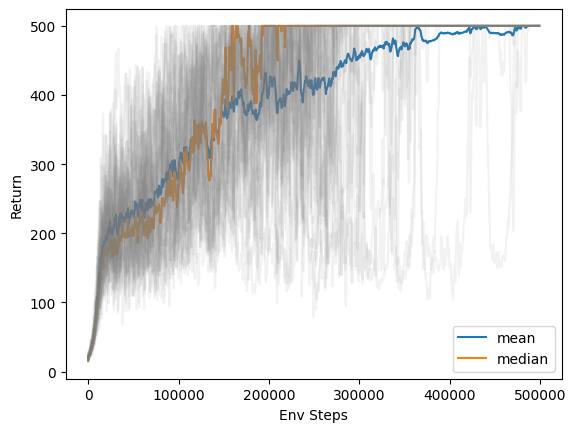

In [17]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence
from flax.training.train_state import TrainState
import distrax
import gymnax
from wrappers import LogWrapper, FlattenObservationWrapper
from einops import rearrange
from functools import partial


class ActorCritic(nn.Module):
    n_acts: Sequence[int]
    activation: str = "tanh"

    def setup(self):
        activation = nn.relu if self.activation == "relu" else nn.tanh
        self.seq_pi = nn.Sequential([
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense( self.n_acts, kernel_init=orthogonal(0.01), bias_init=constant(0.0) )
        ])
        self.seq_critic = nn.Sequential([
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense( 64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0) ),
            activation,
            nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0)),
        ])

    def get_init_state(self, rng):
        return None

    def forward_recurrent(self, state, obs): # shape: (...)
        logits = self.seq_pi(obs)
        val = self.seq_critic(obs)
        # pi = distrax.Categorical(logits=logits)
        # return state, (pi, val[..., 0])
        return state, (logits, val[..., 0])

    def forward_parallel(self, obs): # shape: (n_steps, ...)
        logits = self.seq_pi(obs)
        val = self.seq_critic(obs)
        # pi = distrax.Categorical(logits=logits)
        return logits, val[..., 0]


def make_train(config):
    config["NUM_UPDATES"] = ( config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"] )
    config["MINIBATCH_SIZE"] = ( config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"] )
    env, env_params = gymnax.make(config["ENV_NAME"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)
    
    network = ActorCritic( env.action_space(env_params).n, activation=config["ACTIVATION"] )
    
    def train(rng):
        forward_recurrent = jax.vmap(partial(network.apply, method=network.forward_recurrent),
                                     in_axes=(None, 0, 0))
        forward_parallel = jax.vmap(partial(network.apply, method=network.forward_parallel),
                                    in_axes=(None, 0))

        # TRAIN LOOP
        def _update_step(runner_state, _):
            # rng, train_state, env_params, agent_state, obs, env_state = runner_state
            train_state, env_state, agent_state, obs, rng = runner_state

            # COLLECT TRAJECTORIES
            rollout_step = make_rollout_step_fn(network, env, 4)
            carry = rng, train_state.params, env_params, agent_state, obs, env_state
            carry, traj_batch = jax.lax.scan(rollout_step, carry, None, config["NUM_STEPS"])
            rng, _, _, agent_state, obs, env_state = carry

            last_val = traj_batch['val'][-1]
            traj_batch['adv'], traj_batch['ret'] = calc_gae(traj_batch, last_val, gamma=0.99, gae_lambda=0.95)
            
            update_batch = make_update_batch_fn(network, n_envs=4, n_envs_batch=1, clip_eps=0.2, vf_coef=0.5, ent_coef=0.01)
            carry = rng, train_state, traj_batch
            carry, _ = jax.lax.scan(update_batch, carry, None, 4*4)
            rng, train_state, traj_batch = carry
            
            runner_state = train_state, env_state, agent_state, obs, rng
            # runner_state = rng, train_state, env_params, agent_state, obs, env_state
            return runner_state, traj_batch['info']

        # INIT NETWORK
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, None, init_x, method=network.forward_recurrent)
        tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))
        train_state = TrainState.create( apply_fn=network.apply, params=network_params, tx=tx, )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        _rng = jax.random.split(_rng, config["NUM_ENVS"])
        obs, env_state = jax.vmap(env.reset, in_axes=(0, None))(_rng, env_params)

        # rng, _rng = jax.random.split(rng)
        # _rng = jax.random.split(_rng, config["NUM_ENVS"])
        agent_init_state = jax.vmap(network.get_init_state)(_rng)

        agent_state = jax.tree_map(lambda x: x, agent_init_state)  # copy
        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, agent_state, obs, _rng)
        # runner_state = rng, train_state, env_params, agent_state, obs, env_state
        runner_state, metric = jax.lax.scan( _update_step, runner_state, None, config["NUM_UPDATES"] )
        return {"runner_state": runner_state, "metrics": metric}

    return train


if __name__ == "__main__":
    config = {
        "LR": 2.5e-4,
        "NUM_ENVS": 4,
        "NUM_STEPS": 128,
        "TOTAL_TIMESTEPS": 5e5,
        "UPDATE_EPOCHS": 4,
        "NUM_MINIBATCHES": 4,
        "GAMMA": 0.99,
        "GAE_LAMBDA": 0.95,
        "CLIP_EPS": 0.2,
        "ENT_COEF": 0.01,
        "VF_COEF": 0.5,
        "MAX_GRAD_NORM": 0.5,
        "ACTIVATION": "tanh",
        "ENV_NAME": "CartPole-v1",
        "ANNEAL_LR": False,
        "DEBUG": False,
    }
    rng = jax.random.PRNGKey(30)
    train_fn = jax.jit(jax.vmap(make_train(config)))
    rng, *_rng = jax.random.split(rng, 1+32)
    out = train_fn(jnp.stack(_rng))
    metrics = out["metrics"]
    print(jax.tree_map(lambda x: x.shape, metrics))
    rets = metrics["returned_episode_returns"]  # n_seed, n_iters, n_steps, n_envs
    import matplotlib.pyplot as plt
    n_iters = rets.shape[1]
    steps = jnp.arange(n_iters) * config["NUM_STEPS"] * config["NUM_ENVS"]
    plt.plot(steps, jnp.mean(rets, axis=(0, 2, 3)), label='mean')
    plt.plot(steps, jnp.median(rets, axis=(0, 2, 3)), label='median')
    plt.plot(steps, jnp.mean(rets, axis=(2, 3)).T, c='gray', alpha=0.1)
    plt.legend()
    plt.ylabel('Return')
    plt.xlabel('Env Steps')
    plt.show()
    


Types of agents:
- single obs
- lstm recurrence
- parallel/recurrent agent

Types of envs:
- single env_params
- new env_params every episode
- curriculum of env_params

- PPO impl works with basic agent on CartPole
- PPO impl works with metarl agent on CartPole
- PPO emerges metaRL on gridworld
- PPO emerges metaRL on synthetic env